# RAG application with Azure Open AI & Azure Cognitive Search
## Resume analysis usecase - 02 Embeddings and indexing

### Objective
Let's build an application that will analyse **resume PDF documents using a RAG application.**

<img src="https://github.com/retkowsky/images/blob/master/HR.jpg?raw=true">

**Retrieval-Augmented Generation (RAG)** can exhibit variability in its implementation, but at a fundamental level, employing RAG within an AI-driven application involves the following sequential steps:

- The user submits a query or question.
- The system initiates a search for pertinent documents that hold the potential to address the user's query. These documents are often comprised of proprietary data and are maintained within a document index.
- The system formulates an instruction set for the Language Model (LLM) that encompasses the user's input, the identified relevant documents, and directives on how to utilize these documents to respond to the user's query effectively.
- The system transmits this comprehensive prompt to the Language Model.
- The Language Model processes the prompt and generates a response to the user's question, drawing upon the context provided. This response constitutes the output of our system.

### Steps
- Uploading PDF documents into an Azure Cognitive Search Index
- Use of some Azure Cognitive Search queries to get some answers
- Use a GPT model to analyse the answer (summmary, keywords generation)
- Get the text from the document and the reference to validate the proposed answer
- Chatbot experience using Azure Open AI to ask questions and get results provided by AI with references

### Process
<img src="https://github.com/retkowsky/images/blob/master/rag.png?raw=true" width=800>

In [1]:
#%pip install azure-search-documents==11.4.0b8

In [2]:
#%pip install openai==0.28.1

In [3]:
import datetime
import gradio as gr
import langchain
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import random
import sys
import time

from azure_rag import (
    get_storage_info,
    get_stats_from_pdf_file,
    delete_index,
    index_status,
    index_stats,
    ask_gpt,
    openai_text_embeddings,
    upload_docs,
    similarity_comparison,
)
from dotenv import load_dotenv
from IPython.display import FileLink
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores.azuresearch import AzureSearch

In [4]:
print(f"Today: {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today: 16-Nov-2023 11:20:59


In [5]:
get_storage_info()

Total storage: 126.8 GB
- Used: 115.9 GB    91.43%
- Free: 10.8 GB     8.55%


In [6]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")
print(f"Langchain version: {langchain.__version__}")

Python version: 3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]
OpenAI version: 0.28.1
Langchain version: 0.0.300


## 1. Settings

In [7]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

# Azure Cognitive Search
azure_cs_endpoint = os.getenv("AZURE_COGNITIVE_SEARCH_ENDPOINT")
azure_cs_key = os.getenv("AZURE_COGNITIVE_SEARCH_API_KEY")

In [8]:
# Azure Open AI models (Should be deployed on your Azure OpenAI studio)
embed_model: str = "text-embedding-ada-002"  # Embedding model
gptmodel: str = "gpt-35-turbo-16k"  # GPT Model

# Azure Cognitive search index
index_name: str = "resume-rag-demo"

In [9]:
print(f"Embedding model: {embed_model}\nAzure Open AI model: {gptmodel}")
print(f"We will create the Azure Cognitive Search index: {index_name}")

Embedding model: text-embedding-ada-002
Azure Open AI model: gpt-35-turbo-16k
We will create the Azure Cognitive Search index: resume-rag-demo


## 2. PDF documents

In [10]:
PDF_DIR = "cv"

In [11]:
def count_pdf_files_per_dir(top_directory):
    """
    Count PDF files from a dir including sub directories
    """
    pdf_results = {}
    total_pdf = 0

    for root, dirs, files in os.walk(top_directory):
        if ".ipynb_checkpoints" in dirs:
            dirs.remove(".ipynb_checkpoints")
        pdf_count = sum(1 for file in files if file.lower().endswith(".pdf"))
        pdf_results[root] = pdf_count
        total_pdf += pdf_count

    return pdf_results, total_pdf

In [12]:
pdf_results, total_pdf = count_pdf_files_per_dir(PDF_DIR)

for directory, pdf_count in pdf_results.items():
    print(f"Dir: {directory} | Total number of PDF files = {pdf_count}")

print(f"\nTotal of PDF files = {total_pdf}")

Dir: cv | Total number of PDF files = 0
Dir: cv/BUSINESS-DEVELOPMENT | Total number of PDF files = 113
Dir: cv/CONSULTANT | Total number of PDF files = 115
Dir: cv/DESIGNER | Total number of PDF files = 107
Dir: cv/DIGITAL-MEDIA | Total number of PDF files = 96
Dir: cv/ENGINEERING | Total number of PDF files = 118
Dir: cv/INFORMATION-TECHNOLOGY | Total number of PDF files = 120
Dir: cv/SALES | Total number of PDF files = 116

Total of PDF files = 785


In [13]:
def get_pdf_filenames(directory):
    """
    Get PDF files list
    """
    pdf_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(".pdf"):
                pdf_files.append(os.path.join(root, file))

    return pdf_files

In [14]:
pdf_files = get_pdf_filenames(PDF_DIR)
pdf_files[:10]

['cv/BUSINESS-DEVELOPMENT/10228751.pdf',
 'cv/BUSINESS-DEVELOPMENT/10235211.pdf',
 'cv/BUSINESS-DEVELOPMENT/10289113.pdf',
 'cv/BUSINESS-DEVELOPMENT/10501991.pdf',
 'cv/BUSINESS-DEVELOPMENT/10541358.pdf',
 'cv/BUSINESS-DEVELOPMENT/10704573.pdf',
 'cv/BUSINESS-DEVELOPMENT/11088337.pdf',
 'cv/BUSINESS-DEVELOPMENT/11289482.pdf',
 'cv/BUSINESS-DEVELOPMENT/11551946.pdf',
 'cv/BUSINESS-DEVELOPMENT/12059198.pdf']

In [15]:
print(f"Total number of CV PDF files = {len(pdf_files)}")

Total number of CV PDF files = 785


## 3. Loading the PDF documents

We will chunk our PDF documents, do the embeddings and save the content into Azure Cognitive Search

In [16]:
embed_model

'text-embedding-ada-002'

In [18]:
# Embeddings engine
embeddings: OpenAIEmbeddings = OpenAIEmbeddings(engine=embed_model)

In [19]:
# Azure Cognitive Search as the vector store
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=azure_cs_endpoint,
    azure_search_key=azure_cs_key,
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)

In [20]:
vector_store

### Testing the Azure GPT model

In [21]:
messages_history = []
messages_history = ask_gpt("Hello", messages_history, gptmodel)

Hi! How can I assist you today? [{'role': 'user', 'content': 'Hello'}]


In [22]:
messages_history = ask_gpt("What can you do?", messages_history, gptmodel)

As a language model AI, I can help with a wide range of tasks such as:

1. Answering questions
2. Providing information on various topics
3. Assisting with language-related tasks like proofreading, generating creative writing pieces, suggesting synonyms, etc.
4. Offering general advice or recommendations
5. Engaging in friendly conversation or small talk
6. Playing word games or participating in quizzes
7. Translating text
8. Calculating equations or solving math problems
9. Assisting with research tasks
10. Providing brief explanations or summaries of complex subjects

Please note that I am an AI and my responses are generated based on patterns and data rather than personal experience or opinions. [{'role': 'user', 'content': 'Hello'}, {'role': 'user', 'content': 'What can you do?'}]


### Testing the embedded model

In [23]:
prompt1 = "James Bond"
prompt2 = "Ian Fleming"
prompt3 = "Paris"

In [24]:
emb1 = openai_text_embeddings(prompt1, embed_model)
emb2 = openai_text_embeddings(prompt2, embed_model)
emb3 = openai_text_embeddings(prompt3, embed_model)

In [25]:
emb1[:10]

[-0.02183147519826889,
 -0.01227128691971302,
 -0.004935755394399166,
 -0.027629852294921875,
 -0.0020576457027345896,
 0.012037795037031174,
 -0.025748947635293007,
 -0.013737095519900322,
 -0.025256019085645676,
 -0.020871564745903015]

In [26]:
print(f"Vector embeddings size = {len(emb1)}")

Vector embeddings size = 1536


In [27]:
print("Similarity between:", prompt1, "and", prompt1)
similarity_comparison(emb1, emb1)

Similarity between: James Bond and James Bond
❤️ IDENTICAL text (cosine similarity = 1.0)


In [28]:
print("Similarity between:", prompt1, "and", prompt2)
similarity_comparison(emb1, emb2)

Similarity between: James Bond and Ian Fleming
👍 SIMILAR SEMANTIC text (cosine similarity = 0.861230557365285)


In [29]:
print("Similarity between:", prompt1, "and", prompt3)
similarity_comparison(emb1, emb3)

Similarity between: James Bond and Paris
🔥 DIFFERENT text (cosine similarity = 0.78536572662115)


In [30]:
print("Similarity between:", prompt2, "and", prompt3)
similarity_comparison(emb2, emb3)

Similarity between: Ian Fleming and Paris
🔥 DIFFERENT text (cosine similarity = 0.762085241681582)


### Documents statistics

In [31]:
# Let's take a random document
random_pdf = random.choice(pdf_files)
!ls $random_pdf -lh
# Getting stats
print()
get_stats_from_pdf_file(random_pdf)
# Document link
pdf_link = FileLink(path=random_pdf)
pdf_link

-rwxrwxrwx 1 root root 23K Aug  8  2021 cv/ENGINEERING/28923650.pdf

- Number of pages = 3
- Number of paragraphs = 140
- Number of words = 773
- Number of characters = 5751
- Number of tokens = 1204


/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd14sr/code/Users/seretkow/RAG - Resume analysis usecase/cv/ENGINEERING/28923650.pdf

In [32]:
# Let's take a random document
random_pdf = random.choice(pdf_files)
!ls $random_pdf -lh
# Getting stats
print()
get_stats_from_pdf_file(random_pdf)
# Document link
pdf_link = FileLink(path=random_pdf)
pdf_link

-rwxrwxrwx 1 root root 23K Aug  8  2021 cv/CONSULTANT/18227306.pdf

- Number of pages = 3
- Number of paragraphs = 155
- Number of words = 753
- Number of characters = 5691
- Number of tokens = 1123


/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd14sr/code/Users/seretkow/RAG - Resume analysis usecase/cv/CONSULTANT/18227306.pdf

In [33]:
df_data = []

for i in range(len(pdf_files)):
    file_path, nb_pages, nb_paragraphs, nb_words, nb_characters, nb_tokens = get_stats_from_pdf_file(pdf_files[i],
                                                                                                     disp=False,)
    df_data.append([file_path, nb_pages, nb_paragraphs, nb_words, nb_characters, nb_tokens])

df = pd.DataFrame(
    df_data,
    columns=["file_path", "nb_pages", "nb_paragraphs", "nb_words", "nb_characters", "nb_tokens"]
)
df['role'] = df['file_path'].str.split('/').str[1]  # Get role value

In [34]:
df

,file_path,nb_pages,nb_paragraphs,nb_words,nb_characters,nb_tokens,role
0,cv/BUSINESS-DEVELOPMENT/10228751.pdf,2,133,635,4909,935,BUSINESS-DEVELOPMENT
1,cv/BUSINESS-DEVELOPMENT/10235211.pdf,3,217,1206,8495,1720,BUSINESS-DEVELOPMENT
2,cv/BUSINESS-DEVELOPMENT/10289113.pdf,3,114,811,5658,1118,BUSINESS-DEVELOPMENT
3,cv/BUSINESS-DEVELOPMENT/10501991.pdf,3,267,1083,7854,1680,BUSINESS-DEVELOPMENT
4,cv/BUSINESS-DEVELOPMENT/10541358.pdf,3,129,824,6271,1161,BUSINESS-DEVELOPMENT
...,...,...,...,...,...,...,...
780,cv/SALES/87118391.pdf,2,161,672,5256,971,SALES
781,cv/SALES/90682785.pdf,1,59,222,1517,339,SALES
782,cv/SALES/92200491.pdf,2,160,812,5687,1135,SALES
783,cv/SALES/98108571.pdf,1,67,169,1085,264,SALES


In [35]:
df['role'].value_counts(sort=True)

role
INFORMATION-TECHNOLOGY    120
ENGINEERING               118
SALES                     116
CONSULTANT                115
BUSINESS-DEVELOPMENT      113
DESIGNER                  107
DIGITAL-MEDIA              96
Name: count, dtype: int64

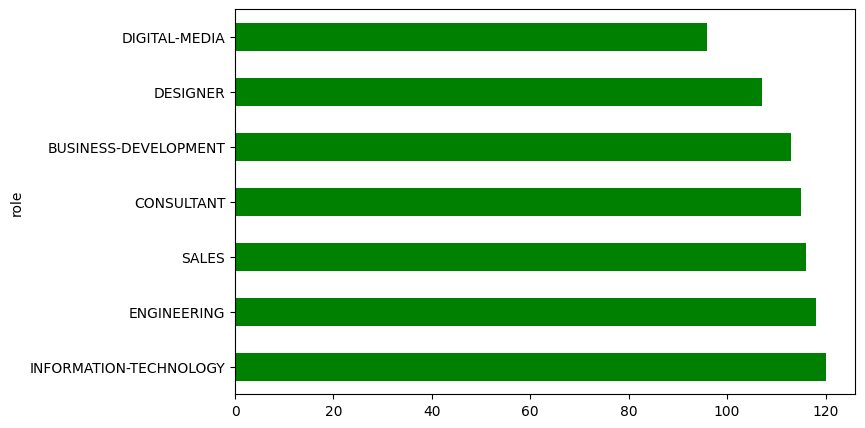

In [36]:
plt.figure(figsize=(8, 5))
df['role'].value_counts(sort=True).plot.barh(color='green')
plt.show()

In [37]:
df.describe()

,nb_pages,nb_paragraphs,nb_words,nb_characters,nb_tokens
count,785.000000,785.000000,785.000000,785.00000,785.000000
mean,2.596178,165.587261,822.335032,6099.06879,1229.335032
std,1.112882,69.632291,375.891890,2762.75628,552.107050
min,0.000000,1.000000,0.000000,0.00000,0.000000
25%,2.000000,123.000000,650.000000,4901.00000,966.000000
50%,3.000000,154.000000,781.000000,5827.00000,1166.000000
75%,3.000000,193.000000,967.000000,7168.00000,1448.000000
max,11.000000,1028.000000,3384.000000,24653.00000,5145.000000


### Processing the PDF docs

In [38]:
start = time.time()
print("Uploading the CV documents into the Azure Cognitive Search index...\n")

for idx in range(len(pdf_files)):
    # Chunking and loading the chunks documents into the Azure Cognitive Search index
    upload_docs(pdf_files[idx], vector_store)
    # Display some prints every each 50 documents processed
    if idx % 25 == 1:
        print(f"Number of PDF processed files = {idx} / {len(pdf_files)}")
        time.sleep(5)

elapsed = time.time() - start
print(f"\nDone. Total number of processed files = {len(pdf_files)}")
print(
    "Elapsed time: "
    + time.strftime(
        "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)
    )
)

Uploading the CV documents into the Azure Cognitive Search index...

Number of PDF processed files = 1 / 785
Number of PDF processed files = 26 / 785
Number of PDF processed files = 51 / 785
Number of PDF processed files = 76 / 785
Number of PDF processed files = 101 / 785
Number of PDF processed files = 126 / 785
Number of PDF processed files = 151 / 785
Number of PDF processed files = 176 / 785
Number of PDF processed files = 201 / 785
Number of PDF processed files = 226 / 785
Number of PDF processed files = 251 / 785
Number of PDF processed files = 276 / 785
Number of PDF processed files = 301 / 785
Number of PDF processed files = 326 / 785
Number of PDF processed files = 351 / 785
Number of PDF processed files = 376 / 785
Number of PDF processed files = 401 / 785
Number of PDF processed files = 426 / 785
Number of PDF processed files = 451 / 785
Number of PDF processed files = 476 / 785
Number of PDF processed files = 501 / 785
Number of PDF processed files = 526 / 785
Number of PD

## 4. Azure Cognitive Search index status

Our index is available and ready to use

In [39]:
print(f"Azure Cognitive Search index = {index_name}")

Azure Cognitive Search index = resume-rag-demo


In [40]:
index_status(index_name, azure_cs_endpoint, azure_cs_key)

Azure Cognitive Search Index: resume-rag-demo 

{
     "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DBE6962627FA4D\"",
     "name": "resume-rag-demo",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "sortable": false,
               "facetable": false,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "synonymMaps": []
          },
          {
               "name": "content",
               "type": "Edm.String",
               "searchable": true,
               "filterable": false,
               "retrievable": true,
               "sortable": false,
               "facet

In [41]:
document_count, storage_size = index_stats(index_name, azure_cs_endpoint, azure_cs_key)

Azure Cognitive Search index status for: resume-rag-demo 

{
  "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 1441,
  "storageSize": 44310293
}


In [42]:
print(f"Number of documents in the index = {document_count}")
print(f"Size of the index = {round(storage_size / (1024 * 1024), 2)} MB")

Number of documents in the index = 1441
Size of the index = 42.26 MB


> Go the next notebook